**Import Neccesary libraries:-**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import tensorflow

**Generate XOR dataset:-**

In [ ]:
# Step 1: Generate XOR dataset
torch.manual_seed(0)
X_train = torch.rand(200, 2) * 2 - 1
y_train = torch.logical_xor(X_train[:, 0] > 0, X_train[:, 1] > 0).float()
y_train = y_train.view(-1, 1)

X_test = torch.rand(200, 2) * 2 - 1
y_test = torch.logical_xor(X_test[:, 0] > 0, X_test[:, 1] > 0).float()
y_test = y_test.view(-1, 1)

# **Define Model:-**

In [ ]:
class MLP_with_Regularization(nn.Module):
    def __init__(self, l1=False, l2=False):
        super(MLP_with_Regularization, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)
        self.l1 = l1
        self.l2 = l2

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def l1_loss(self):
        l1_penalty = 0
        for param in self.parameters():
            l1_penalty += abs(torch.norm(param, p=1))
        return l1_penalty

    def l2_loss(self):
        l2_penalty = 0
        for param in self.parameters():
            l2_penalty += torch.norm(param, p=2) ** 2
        return l2_penalty

# **Train the models**

In [ ]:
def train_model(model, criterion, optimizer, X_train, y_train, alpha=0, num_epochs=1000):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        regularization_loss = 0
        if alpha > 0:
            if model.l1:
                regularization_loss = alpha * model.l1_loss()
            elif model.l2:
                regularization_loss = alpha * model.l2_loss()
            else:
                regularization_loss = 0
            loss += regularization_loss
        loss.backward()
        optimizer.step()



# **Accuracy:-**

In [ ]:
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.round(outputs)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
    return accuracy

# **Initialize the Model:-**

In [ ]:
# Initialize models
mlp = MLP_with_Regularization()
mlp_l1 = MLP_with_Regularization(l1=True)
mlp_l2 = MLP_with_Regularization(l2=True)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.1)
optimizer_mlp_l1 = optim.Adam(mlp_l1.parameters(), lr=0.1)  # L1 regularization
optimizer_mlp_l2 = optim.Adam(mlp_l2.parameters(), lr=0.1)  # L2 regularization

# Train the models
train_model(mlp, criterion, optimizer_mlp, X_train, y_train, alpha=0)
train_model(mlp_l1, criterion, optimizer_mlp_l1, X_train, y_train, alpha=0.01)
train_model(mlp_l2, criterion, optimizer_mlp_l2, X_train, y_train, alpha=0.01)

# Evaluate the models
accuracy_mlp = evaluate_model(mlp, X_test, y_test)
accuracy_mlp_l1 = evaluate_model(mlp_l1, X_test, y_test)
accuracy_mlp_l2 = evaluate_model(mlp_l2, X_test, y_test)

print("Accuracy of MLP with no regularization: ", accuracy_mlp)
print("Accuracy of MLP with L1 regularization: ", accuracy_mlp_l1)
print("Accuracy of MLP with L2 regularization: ", accuracy_mlp_l2)


Accuracy of MLP with no regularization:  0.965
Accuracy of MLP with L1 regularization:  0.94
Accuracy of MLP with L2 regularization:  0.98


In [ ]:
print(mlp)

MLP_with_Regularization(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


# **Plot The Graph:-**

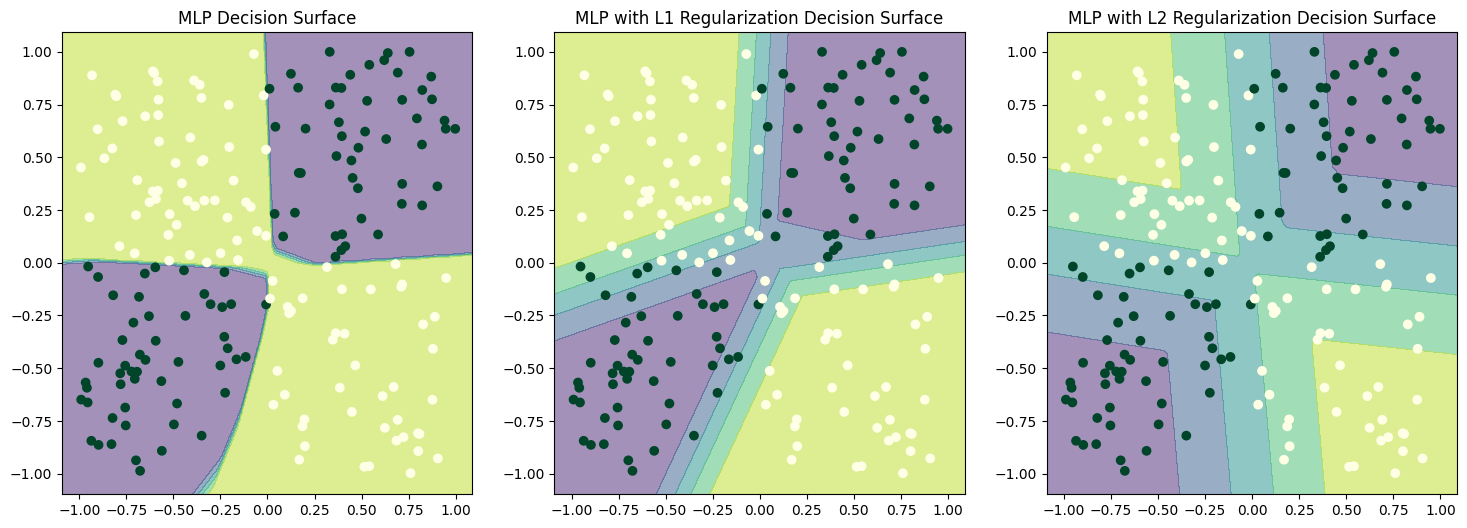

In [ ]:

def plot_decision_surface(ax, model, title):
    h = 0.01
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h))
    inputs = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    Z = model(inputs).reshape(xx.shape)
    ax.contourf(xx.detach().numpy(), yy.detach().numpy(), Z.detach().numpy(), levels=4, alpha=0.5)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="YlGn_r")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_decision_surface(axs[0], mlp, "MLP Decision Surface")
plot_decision_surface(axs[1], mlp_l1, "MLP with L1 Regularization Decision Surface")
plot_decision_surface(axs[2], mlp_l2, "MLP with L2 Regularization Decision Surface")

plt.show()

# **Logistic Regression Model**

In [ ]:

# Transform features into polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_poly, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_poly, dtype=torch.float32)

# Convert y_train to a NumPy array and reshape if needed
y_train_array = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train

# Convert NumPy array to PyTorch tensor
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)

# Convert y_test to a NumPy array and reshape if needed
y_test_array = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test

# Convert NumPy array to PyTorch tensor
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))
        return x

# Train the model
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs=1000):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

# Initialize the model
input_dim = X_train_tensor.shape[1]
log_reg = LogisticRegression(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(log_reg.parameters(), lr=0.1)

# Train the model
train_model(log_reg, criterion, optimizer, X_train_tensor, y_train_tensor)

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.round(outputs)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
    return accuracy

# Evaluate the model
accuracy_log_reg = evaluate_model(log_reg, X_test_tensor, y_test_tensor)

print("Accuracy of Logistic Regression with polynomial features: ", accuracy_log_reg)


Accuracy of Logistic Regression with polynomial features:  0.975


# **Graph of Logistic Regression**

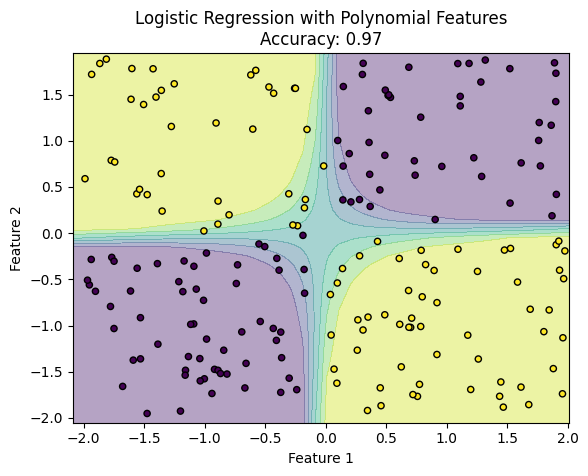

In [ ]:
# Plot the decision boundary
x_min, x_max = X_train_poly[:, 0].min() - 0.1, X_train_poly[:, 0].max() + 0.1
y_min, y_max = X_train_poly[:, 1].min() - 0.1, X_train_poly[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
Z = log_reg(torch.tensor(poly.transform(grid_tensor), dtype=torch.float32)).detach().numpy()
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_poly[:, 0], X_train_poly[:, 1], c=y_train_array, s=20, edgecolor='k')
plt.title("Logistic Regression with Polynomial Features\nAccuracy: {:.2f}".format(accuracy_log_reg))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#**a. MLP (Multilayer Perceptron):**

**The MLP should be able to learn the XOR function as it is capable of capturing non-linear relationships between features.
It is expected to achieve good results on the XOR dataset, capturing the shape of the XOR function with high accuracy.
The decision surface should consist of non-linear boundaries separating the two classes.**
#**b. MLP with L1 Regularization:**

**L1 regularization encourages sparsity in the weights, which can help in feature selection.
By choosing an appropriate penalty coefficient (through validation), the model can achieve good results on the XOR dataset.
The decision surface may exhibit some degree of sparsity, with some features having zero weights.**
#**c. MLP with L2 Regularization:**

**L2 regularization penalizes large weights, leading to a smoother decision surface.
Similar to L1 regularization, choosing an appropriate penalty coefficient can help achieve good results on the XOR dataset.
The decision surface may be smoother compared to the MLP without regularization.**
#**d. Logistic Regression with Polynomial Features:**

**Adding polynomial features allows logistic regression to capture non-linear relationships in the data.By including additional features (e.g., x1^2, x2^2, x1*x2), logistic regression can learn a decision boundary that captures the XOR function.The decision surface may exhibit curved boundaries, reflecting the non-linear nature of the XOR function.**
**Overall, the expectation is that all models should be able to capture the shape of the XOR function to some degree. The decision surfaces for each model will vary based on the regularization technique used and the complexity of the model. Visualizing these decision surfaces will provide insights into how each model is performing on the XOR dataset.**